In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp utils

# Objective 1 : Predict RUL


Predictive Maintenance (PdM) is a great application of Survival Analysis since it consists in predicting when equipment failure will occur and therefore alerting the maintenance team to prevent that failure.

### ` Objectives`
> - To estimate Remaining Useful Time(RUL) of a machine/component

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import shap
from boruta import BorutaPy

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

from pycaret.regression import *

from PredictiveMaintenance2 import Datasets,Visualize,FeatureEng,Model

### load dataset

In [ ]:
# load pre processed dataset
machineData = pd.read_csv('Machine_Data_Preprocessed.csv')
machineData.head(2)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,RUL,SurvivalTime
0,2015-01-01,0,0,141503600,0,0,1,19,494462,16,16,3,18,1
1,2015-01-01,1,0,55587136,0,0,0,7,199132,0,0,0,214,1


In [ ]:
# convert to datetime 
machineData['date'] = pd.to_datetime(machineData['date'])

In [ ]:
# sort values by device and date
machineData = machineData.sort_values(['device','date'],ascending= True).reset_index(drop=True)
machineData.head(2)

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,RUL,SurvivalTime
0,2015-01-01,0,0,141503600,0,0,1,19,494462,16,16,3,18,1
1,2015-01-02,0,0,161679800,0,0,1,19,495730,16,16,3,17,2


In [ ]:
unique_device_types = pd.DataFrame(machineData.groupby(['device']).agg(['count']))
unique_device_types.shape

(137, 13)

there are 137 devices - out which 106 devices have failed during observation and 31 devices have lasted till the end of observation.

# Modeling - without Feature selection

### split the data

In [ ]:
# fit entire dataset when working with feature selection
x = machineData.drop(['date','failure','RUL','SurvivalTime'],axis=1)
y = machineData['RUL']

# split the data
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

### fit the model

In [ ]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

### predictions

In [ ]:
# Make predictions on the testing data
y_pred = rf_model.predict(x_test)

### validations

In [ ]:
# Calculate the Mean Squared Error (MSE) and R-squared value of the predictions
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
# Print the results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared value: {r2}")

Mean Squared Error: 105.06250148795198
Mean Absolute Error: 4.667849196330892
R-squared value: 0.9842798735885625


# Modeling with feature selection - randomforest regressor

### Boruta



In [ ]:
#| hide
# but do we use boruta for feature selection in a time series data???

In [ ]:
# fit entire dataset when working with feature selection
x = machineData.drop(['date','failure','RUL','SurvivalTime'],axis=1)
y = machineData['RUL']

# convert to numpy to apply boruta
x_arr = x.to_numpy()
y_arr = y.to_numpy()

In [ ]:
# Instantiate the random forest regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
# Instantiate the Boruta object
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, alpha=0.05, max_iter=10, random_state=42)

# Fit the Boruta object to the training data
boruta.fit(x_arr, y_arr)

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 10
Confirmed: 	9
Tentative: 	1
Rejected: 	0


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	9
Tentative: 	0
Rejected: 	0


BorutaPy(estimator=RandomForestRegressor(n_estimators=44,
                                         random_state=RandomState(MT19937) at 0x2250A8F1E40),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2250A8F1E40, verbose=2)

In [ ]:
#| hide
# Get the selected features
selected_features = boruta.support_
selected_features

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True])

In [ ]:
#| hide
# zip my names, ranks, and decisions in a single iterable
feature_ranks = list(zip(x.columns, 
                         boruta.ranking_, 
                         boruta.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: device                    Rank: 1,  Keep: True
Feature: metric1                   Rank: 2,  Keep: False
Feature: metric2                   Rank: 1,  Keep: True
Feature: metric3                   Rank: 1,  Keep: True
Feature: metric4                   Rank: 1,  Keep: True
Feature: metric5                   Rank: 1,  Keep: True
Feature: metric6                   Rank: 1,  Keep: True
Feature: metric7                   Rank: 1,  Keep: True
Feature: metric8                   Rank: 1,  Keep: True
Feature: metric9                   Rank: 1,  Keep: True


In [ ]:
# call transform() on x to filter it down to selected features
x_selected = boruta.transform(x_arr)

In [ ]:
#| hide
# --------- or -------------#
# Train a regression model using the selected features
x_selected = x_arr[:, selected_features]

### split the data

In [ ]:
x = machineData.drop(['date','failure','RUL','SurvivalTime'],axis=1)
y = machineData['RUL']

# split the data
x_train, x_test, y_train, y_test = train_test_split(x_selected,y, test_size=0.2, random_state=42)


### fit the model

In [ ]:
# Create a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_model.fit(x_train, y_train)

RandomForestRegressor(random_state=42)

### Predictions


In [ ]:
# Make predictions on the testing data
y_pred = rf_model.predict(x_test)

### Validations

In [ ]:
# Calculate the Mean Squared Error (MSE) and R-squared value of the predictions
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
# Print the results
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared value: {r2}")

Mean Squared Error: 83.94598232058489
Mean Absolute Error: 4.123105926662051
R-squared value: 0.9874394628423803


### interpret the model

In [ ]:
# shap to feature explanation

# Fit the explainer to sample x_test/ full dataset x_selected
explainer = shap.Explainer(rf_model.predict, x_selected)

# Calculates the SHAP values - It takes some time
shap_values = explainer(x_selected)
shap_values

Exact explainer: 19806it [3:41:26,  1.49it/s]                                                                          


.values =
array([[ 3.73907837e+00,  1.32506122e+00, -1.17333856e-01, ...,
        -2.73252130e+00, -2.40410608e+00, -7.34367051e+00],
       [ 3.73907837e+00,  1.32506122e+00, -1.17333856e-01, ...,
        -2.73252130e+00, -2.40410608e+00, -7.34367051e+00],
       [ 3.70568670e+00,  1.32506122e+00, -1.17543856e-01, ...,
        -2.73768463e+00, -2.42076108e+00, -7.36847884e+00],
       ...,
       [-7.33903858e+01,  1.89993439e+00, -1.93152320e-02, ...,
         2.65801312e-01,  2.58013244e-01, -4.20636435e-01],
       [-7.33903858e+01,  1.89993439e+00, -1.93152320e-02, ...,
         2.65801312e-01,  2.58013244e-01, -4.20636435e-01],
       [-7.33903858e+01,  1.89993439e+00, -1.93152320e-02, ...,
         2.65801312e-01,  2.58013244e-01, -4.20636435e-01]])

.base_values =
array([115.95513874, 115.95513874, 115.95513874, ..., 115.95513874,
       115.95513874, 115.95513874])

.data =
array([[  0,   0,   0, ...,  16,  16,   3],
       [  0,   0,   0, ...,  16,  16,   3],
       [  0,   0

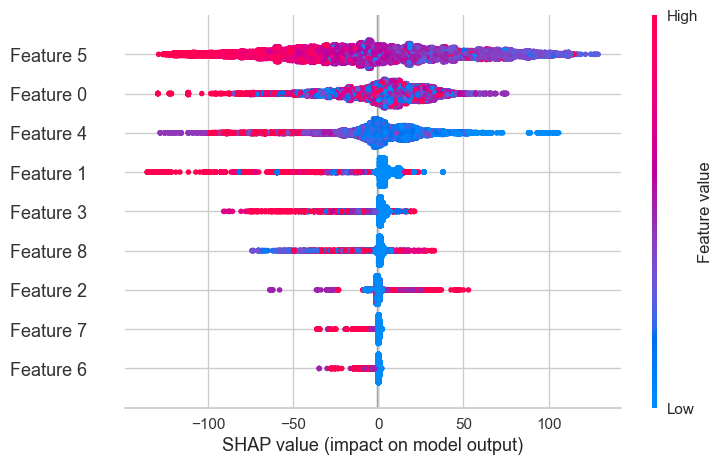

In [ ]:
# bee swarm plot to understand feature importance on dataset
shap.plots.beeswarm(shap_values)

In [ ]:
#| hide
# Perform cross-validation on the model
# use rolling cross validation for time series data - reason for negative scores
"""
scores = cross_val_score(rf_model,x,y, scoring='neg_mean_absolute_error',cv=5)
print('Cross-Validation Scores:', scores)
print('Mean Cross-Validation Score:', np.mean(scores))
"""

"\nscores = cross_val_score(rf_model,x,y, scoring='neg_mean_absolute_error',cv=5)\nprint('Cross-Validation Scores:', scores)\nprint('Mean Cross-Validation Score:', np.mean(scores))\n"

# Model - Pycaret
Model selection, find best model for the task

In [ ]:
#| hide
# test data can be specified
# Initialize setup
"""
reg_setup = setup(data=machineData, 
                  target='RUL', 
                  index = True,
                  train_size= 0.7,
                  test_data = None, 
                  ignore_features=['date','failure','SurvivalTime'],
                  preprocess= True,
                  remove_multicollinearity= False,
                  multicollinearity_threshold=0.8,
                  transformation=False,
                  normalize=True,
                  normalize_method='minmax',
                  feature_selection=True,
                  feature_selection_method='classic',
                  feature_selection_estimator='lightgbm',
                  data_split_shuffle=False,
                  fold_strategy='timeseries',
                  fold = 5,
                  verbose = True
                 )
"""
# model is performing better with 8/9 features selected but 2-3 is not worst either

"\nreg_setup = setup(data=machineData, \n                  target='RUL', \n                  index = True,\n                  train_size= 0.7,\n                  test_data = None, \n                  ignore_features=['date','failure','SurvivalTime'],\n                  preprocess= True,\n                  remove_multicollinearity= False,\n                  multicollinearity_threshold=0.8,\n                  transformation=False,\n                  normalize=True,\n                  normalize_method='minmax',\n                  feature_selection=True,\n                  feature_selection_method='classic',\n                  feature_selection_estimator='lightgbm',\n                  data_split_shuffle=False,\n                  fold_strategy='timeseries',\n                  fold = 5,\n                  verbose = True\n                 )\n"

In [ ]:
# without any customization
reg_normal_setup = setup(data=machineData,
                        target = 'RUL',
                        ignore_features=['date','failure','SurvivalTime'],
                        )

,Description,Value
0,Session id,937
1,Target,RUL
2,Target type,Regression
3,Original data shape,"(19805, 14)"
4,Transformed data shape,"(19805, 11)"
5,Transformed train set shape,"(13863, 11)"
6,Transformed test set shape,"(5942, 11)"
7,Ignore features,3
8,Numeric features,10
9,Preprocess,True


In [ ]:
#| hide
# create models with desired algorithms
# rf_model = create_model('model_name',cross_validation=True,fold=10)

In [ ]:
# best_model = compare_models(sort='MAE')
# TT - training time (sec) , MAPE = mean absolute percentage error
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4.7575,101.3286,10.0449,0.9853,0.2840,0.1464,1.1630
rf,Random Forest Regressor,5.1086,108.5043,10.3796,0.9843,0.3124,0.1894,1.5270
xgboost,Extreme Gradient Boosting,7.7985,137.9218,11.7297,0.9800,0.3801,0.3016,0.7830
dt,Decision Tree Regressor,4.9681,162.1656,12.6559,0.9765,0.3251,0.1556,0.5590
catboost,CatBoost Regressor,11.4940,238.4826,15.4325,0.9654,0.4614,0.4280,2.2080
lightgbm,Light Gradient Boosting Machine,13.3388,332.2891,18.2104,0.9519,0.5164,0.5319,0.7670
gbr,Gradient Boosting Regressor,32.8338,1855.2679,43.0527,0.7312,0.7725,1.2410,0.7690
ada,AdaBoost Regressor,54.0198,4126.8465,64.2232,0.4018,1.0351,2.2930,0.6490
ridge,Ridge Regression,65.0578,6202.9049,78.7452,0.1009,1.1209,2.6862,0.6190
llar,Lasso Least Angle Regression,65.0600,6202.6741,78.7438,0.1009,1.1209,2.6867,0.5230


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
print(best_model)

ExtraTreesRegressor(n_jobs=-1, random_state=937)


### Hyperparameter tuning
Find best combination of hyperparameters from Hyperparameter space.
- Every combination in HP space is model
- To search effective combination of HP - two approaches 
- `GridSeachCV` and `RandomSeachCV` where `CV` = cross-validation
- with idea of hyperparameter tuning, split the data into trainig, testing and validation to prevent 'Data Leakage'

In [ ]:
# tune the hyper parameters of the best model - case when : tree model
"""
important : max_features, min_samples_leaf,n_estimators
"""
params = {
    'n_estimators': [100],           #number of trees
    'criterion': ['absolute_error'], #['squared_error','absolute_error','friedman_mse','poisson']
    'max_depth': [None],             # if none nodes are expanded until all leaves are pure
    'min_samples_split': [2],        # min samples required to split internal node [int or float or default=2]
    'min_samples_leaf' : [1],        # a split is considered if both branches has min_samples_leaf [int or float or default=1]
    # min_weight_fraction_leaf : 0.0
    'max_features':[1.0],            # max features to consider at each split [int or float or none or 'sqrt' or 'log'] default = 1.0 => max_features=n_features
    'max_leaf_nodes': [None],        # int = first best nodes or infinite nodes if none
    'min_impurity_decrease' : [0.0], # node split is considered if decrease of impurity due to this split < min_impurity_decrease
    'bootstrap':[False],             # True : use bootstrap samples to build the tree , False: Use whole dataset to build each tree
    'oob_score' : [False],           # out of bag samples to estimate generalization score , only when bootstrap= True
    # 'n_jobs'=1,                    # number of jobs to run in parallel
    'random_state' : [None],         # for bootstrapping, draw of split of max_Features
    'verbose' : [True], 
    # 'warm_start' : False           # True : reuse the solution of previous call to add estimator to ensemble
    'ccp_alpha' : [0.0],             # minimal cost complexity pruning ,0.0 = no pruning , largest cost complexity < ccp_alpha is choosen
    'max_samples' : [None]           #max samples to draw to train estimator (if bootstrapping = True)   
}

In [ ]:
extra_tree_tuned_model = tune_model(best_model,
                         fold = 2,
                         n_iter=10,
                         custom_grid = params,
                         optimize='MAE',
                         search_library='scikit-learn',
                         search_algorithm='random',
                         choose_better = True, # True : return only better performing model b/w original estimator or tuned model
                         return_tuner= False, # if True: returns tuner object , False: returns estimator object very important difference
                         return_train_score=True
                        )
                        

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
print(extra_tree_tuned_model)

ExtraTreesRegressor(n_jobs=-1, random_state=937)


In [ ]:
# avaiable plots in pycaret
available_plots = [
    'pipeline', # schematic drawing of the preprocessing pipeline
    'residuals_interactive', # interactive residual plots
    'residuals', 
    'error',
    'cooks', # cooks distance plot ?
    'rfe',
    'learning',
    'vc',
    'manifold',
    'feature',
    'feature_all',
    'parameter',
    'tree' # Decision tree
]

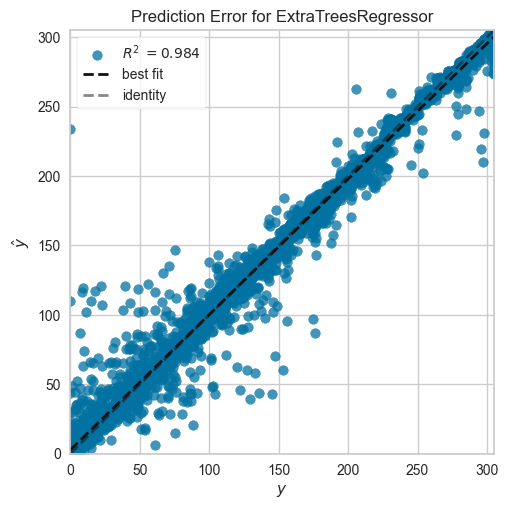

In [ ]:
plot_model(extra_tree_tuned_model,plot='error')

In [ ]:
plot_model(best_model,plot="error")

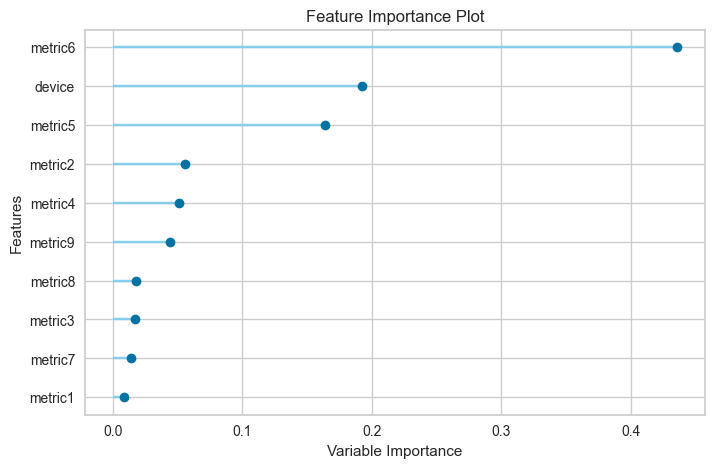

In [ ]:
plot_model(extra_tree_tuned_model,plot='feature')

In [ ]:
# Interpret the model - dependent on SHAP
# 40 minutes
interpret_model(extra_tree_tuned_model,plot='reason',observation=32)

In [ ]:
# save model
# save_model(best_model,'Extra_Trees_regressor_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\Lalitha\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['device', 'metric1', 'metric2',
                                              'metric3', 'metric4', 'metric5',
                                              'metric6', 'metric7', 'metric8',
                                              'metric9'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  ExtraTreesRegressor(n_jobs=-1, random_state=937))]),
 'Extra_Trees_regressor_model.pkl')

In [ ]:
#| hide
# get_leaderboard same as score board after training all models
# get_leaderboard()

In [ ]:
#dashboard(model) - uses explainerDashboard library 
dashboard_kwargs = {
    'shap_interaction':False,
    'show_metrics':['root_mean_squared_error', 'mean_absolute_error','R-squared']
}
dashboard(best_model,display_format='inline',dashboard_kwargs=dashboard_kwargs)

Changing class type to RandomForestRegressionExplainer...
Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Generating layout...
Calculating shap values...


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()